#感情データのモデル作成及びテスト




90分対策  
F12を開いて以下のスクリプトをコンソールで実行  
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

  
60秒ごとに接続

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/data分析/Face Experience/'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
train_angry_dir = os.path.join(train_dir, 'angry')
train_disgust_dir = os.path.join(train_dir, 'disgust')
train_fear_dir = os.path.join(train_dir, 'fear')
train_happy_dir = os.path.join(train_dir, 'happy')
train_neutral_dir = os.path.join(train_dir, 'neutral')
train_sad_dir = os.path.join(train_dir, 'sad')
train_suprise_dir = os.path.join(train_dir, 'suprise')

valid_angry_dir = os.path.join(valid_dir, 'angry')
valid_disgust_dir = os.path.join(valid_dir, 'disgust')
valid_fear_dir = os.path.join(valid_dir, 'fear')
valid_happy_dir = os.path.join(valid_dir, 'happy')
valid_neutral_dir = os.path.join(valid_dir, 'neutral')
valid_sad_dir = os.path.join(valid_dir, 'sad')
vaild_suprise_dir = os.path.join(valid_dir, 'suprise')

test_angry_dir = os.path.join(test_dir, 'angry')
test_disgust_dir = os.path.join(test_dir, 'disgust')
test_fear_dir = os.path.join(test_dir, 'fear')
test_happy_dir = os.path.join(test_dir, 'happy')
test_neutral_dir = os.path.join(test_dir, 'neutral')
test_sad_dir = os.path.join(test_dir, 'sad')
test_suprise_dir = os.path.join(test_dir, 'suprise')


##binaryとcategoricalの違い
binaryは0か1かを判定するので2値判定するのに適している  
categoricalは多クラス分類するのに適している  
今回は2つの値を入手する必要があったためcategoricalを使用

##batch_size
ミニバッチ学習に使われるバッチのサイズ  
データの枚数で割り切れるように調整する必要がある  
データの数=batch_size*epochs

##その他
rescaleは正規化のための仕組みでRGB(0~255)で読み込まれた各画素のRGB値を0から1に収まるように正規化
  
target_sizeでサイズ調整

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (48, 48),
    batch_size = 3000,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size = (48, 48),
    batch_size = 914,
    class_mode = 'categorical'
)

Found 92975 images belonging to 7 classes.
Found 17366 images belonging to 7 classes.


92975 batch_size=3719,steps=25  
17366 batch_size=457,steps=38

##モデル作成
出力層はsigmoidとsoftmax  
sigmoidは2値、softmaxは多クラスの時に使用  
softmaxを使うとどの特徴にも当てはまらないものも高い数字が出る可能性がある  
input_shape:横,縦,チャンネル数(今回はRGBなので3)  
層を深くしすぎると表現力を失い一直線になる  
Conv2D(16,(3,3)): 3*3の大きさのフィルタを16種類使用  
activation='relu': Relu関数　0より大きい場合はそのまま、0未満は0  
kernel_initializerで重みの初期化  
Relu関数の場合はheの初期値を使うといいかも?




In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3),kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'))
model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu',kernel_initializer='he_normal'))
model.add(layers.Dense(256, activation='relu',kernel_initializer='he_normal'))
model.add(layers.Dense(7, activation='softmax')) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0

##Adam
MomentumとAdaGradを融合したような手法

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

モデルを保存　再利用するときに便利

In [ ]:
model.save('/content/drive/MyDrive/data分析/Face Experience/facemodel2.h5')

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=30,
                              epochs=20,
                              validation_data=validation_generator,
                              validation_steps=19)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
30/30 [==============================] - 18440s 617s/step - loss: 1.7258 - accuracy: 0.3375 - val_loss: 1.6358 - val_accuracy: 0.3416
Epoch 2/20
30/30 [==============================] - 370s 12s/step - loss: 1.6003 - accuracy: 0.3846 - val_loss: 1.6104 - val_accuracy: 0.3526
Epoch 3/20
30/30 [==============================] - 347s 11s/step - loss: 1.5612 - accuracy: 0.4069 - val_loss: 1.5936 - val_accuracy: 0.3720
Epoch 4/20
30/30 [==============================] - 342s 11s/step - loss: 1.5239 - accuracy: 0.4276 - val_loss: 1.5842 - val_accuracy: 0.3836
Epoch 5/20
30/30 [==============================] - 349s 12s/step - loss: 1.4908 - accuracy: 0.4509 - val_loss: 1.5782 - val_accuracy: 0.3836
Epoch 6/20
30/30 [==============================] - 354s 12s/step - loss: 1.4631 - accuracy: 0.4629 - val_loss: 1.5757 - val_accuracy: 0.3961
Epoch 7/20
30/30 [==============================] - 355s 12s/step - loss: 1.4416 - accuracy: 0.4732 - val_loss: 1.5680 - val_accuracy: 0.4001
Epo

重みを保存　再利用するときに便利


In [ ]:
model.save('/content/drive/MyDrive/data分析/Face Experience/faceweight2.h5')

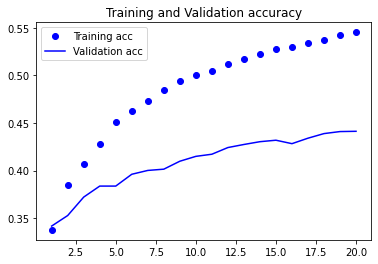

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/data分析/Face Experience/accuracy2.png')
plt.show()
plt.close()

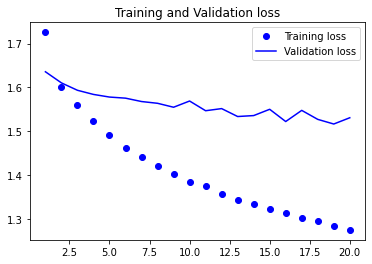

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/data分析/Face Experience/loss2.png')
plt.show()
plt.close()

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('/content/drive/MyDrive/data分析/Face Experience/history2.csv')

In [ ]:
hist_df

,loss,accuracy,val_loss,val_accuracy
0,1.725796,0.337516,1.635772,0.341587
1,1.600252,0.384573,1.610435,0.352643
2,1.561156,0.406946,1.593612,0.372049
3,1.523873,0.427574,1.584172,0.383623
4,1.490752,0.450870,1.578182,0.383623
5,1.463126,0.462906,1.575678,0.396061
6,1.441560,0.473176,1.567994,0.400092
7,1.421092,0.484757,1.563972,0.401417
8,1.402422,0.493715,1.554997,0.409766
9,1.385409,0.500739,1.569161,0.414891


## 補足
ハイパーパラメータチューニング

In [ ]:
# モデルと重みの読み込み
model.load_weights('/content/drive/MyDrive/data分析/Face Experience/faceweight2.h5')

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generater = test_datagen.flow_from_directory(
    test_dir,
    target_size =  (48, 48),
    batch_size = 309,
    class_mode = 'categorical'
)

Found 15452 images belonging to 7 classes.


In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generater, steps=50)
print('test acc:', test_acc)
print('test loss', test_loss)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.4506250023841858
test loss 1.4863381385803223


In [ ]:
MEMBER = ["A","B","C","D","E","F","G"]
y_true = np.argmax(test_generater,axis=1)
cm = confusion_matrix(y_true,y_pred)
cm = pd.DataFrame(data=cm,index=MEMBER,columns=MEMBER)
sns.heatmap(cm,square=True,cbar=True,annot=True,cmap='Blues')
plt.show()

KeyboardInterrupt: ignored

In [ ]:
cm = confusion_matrix(y_true,y_pred)
cm = pd.DataFrame(data=cm,index=MEMBER,columns=MEMBER)
sns.heatmap(cm,square=True,cbar=True,annot=True,cmap='Blues')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#best_model=model.load_weights('/content/drive/MyDrive/data分析/Face Experience/faceweight2.h5')
predictions = model.predict(test_generater)


KeyboardInterrupt: ignored

In [ ]:
threshold = 0.5
y_pred = y_pred_proba >= threshold
cmd = ConfusionMatrixDisplay(confusion, [0,1])
cmd.plot(cmap=plt.cm.Blues)